<a href="https://colab.research.google.com/github/mopfun/Project_4_Grp_1/blob/MI/Netflix_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question: Can we predict whether a movie will make it into Netflix's Top 10?

### reference:
Kaggle notebooks Titanic|EDA|Model|CustomPipelines https://www.kaggle.com/code/ravi20076/titanic-eda-model-custompipelines

In [4]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import pandas as pd
import numpy as np

# Import LogistRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import Seaborn and Matplotlib for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# To save logistical regression and random forest models
import joblib

# Import Dense and LeakyReLu layers for neural network model
from tensorflow.keras.layers import Dense, LeakyReLU

In [5]:
#Check where this is file is stored
import os
os.getcwd()

'/content'

# Make sure you upload final_data.csv to the **content folder** in google colab every time you run this file

**Column Definitions:**
- **Rating:** Avgerage IMDb user rating on a scale of 1 to 10
- **Votes:** Total number of user votes that contributed to the IMDB rating
- **Meta Score:** Metacritic score based on critic reviews, ranging from 0-100
- **PR Rating:** Aged based rating PG, PG-13, R
- **Duration:** Total runtime of the movie
- **Netflix top 10:** Indicates if the movie made it into Netflix's top 10 list (1=Yes, 0=No)

In [6]:
# Import in csv file
df = pd.read_csv("final_data.csv")
df.head()

,row_id,movie_name,rating,votes,meta_score,genre0,genre1,genre2,genre3,pr_rating,...,cast0,cast1,cast2,cast3,cast4,director,number_rating,netflix_top_10,weekly_hours_viewed,weekly_views
0,0,Leave the World Behind,6.5,90000.0,67,"Drama, Mystery, Thriller",Drama,Mystery,Thriller,R,...,"Julia Roberts, Mahershala Ali, Ethan Hawke, My...",Julia Roberts,Mahershala Ali,Ethan Hawke,Myha'la,Sam Esmail,4,1,98700000.0,41700000.0
1,16,Family Switch,5.6,16000.0,37,"Comedy, Family",Comedy,Family,NaN,PG,...,"Jennifer Garner, Ed Helms, Emma Myers, Brady Noon",Jennifer Garner,Ed Helms,Emma Myers,Brady Noon,McG,2,1,39200000.0,22200000.0
2,19,How the Grinch Stole Christmas,6.3,280000.0,46,"Comedy, Family, Fantasy",Comedy,Family,Fantasy,PG,...,"Jim Carrey, Taylor Momsen, Kelley, Jeffrey Tambor",Jim Carrey,Taylor Momsen,Kelley,Jeffrey Tambor,Ron Howard,2,1,7530000.0,NaN
3,23,Leo,7.0,21000.0,65,"Animation, Comedy, Family",Animation,Comedy,Family,PG,...,"Adam Sandler, Bill Burr, Cecily Strong, Jason ...",Adam Sandler,Bill Burr,Cecily Strong,Jason Alexander,Robert MarianettiRobert SmigelDavid Wachtenheim,2,1,61700000.0,34600000.0
4,27,Chicken Run: Dawn of the Nugget,6.5,6300.0,63,"Animation, Adventure, Comedy",Animation,Adventure,Comedy,PG,...,"Thandiwe Newton, Zachary Levi, Bella Ramsey, I...",Thandiwe Newton,Zachary Levi,Bella Ramsey,Imelda Staunton,Sam Fell,2,1,20300000.0,11900000.0


In [7]:
# Overview data types, non-nulls values, columns and row
# weekly_hours_viewed and weekly_views are missing a lot of data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   row_id               1734 non-null   int64  
 1   movie_name           1734 non-null   object 
 2   rating               1728 non-null   float64
 3   votes                1728 non-null   float64
 4   meta_score           1734 non-null   int64  
 5   genre0               1734 non-null   object 
 6   genre1               1734 non-null   object 
 7   genre2               1608 non-null   object 
 8   genre3               1219 non-null   object 
 9   pr_rating            1734 non-null   object 
 10  year                 1734 non-null   int64  
 11  duration             1734 non-null   float64
 12  cast0                1734 non-null   object 
 13  cast1                1734 non-null   object 
 14  cast2                1733 non-null   object 
 15  cast3                1733 non-null   o

In [8]:
# Determine the number of unique values in each column.
df.nunique()

,0
row_id,1734
movie_name,1704
rating,58
votes,673
meta_score,85
genre0,236
genre1,15
genre2,19
genre3,18
pr_rating,6


In [9]:
# Check the statistical summary of the numerical data
df.describe()

,row_id,rating,votes,meta_score,year,duration,number_rating,netflix_top_10,weekly_hours_viewed,weekly_views
count,1734.000000,1728.000000,1.728000e+03,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1.750000e+02,4.800000e+01
mean,974.822376,6.952604,2.975975e+05,62.046713,2007.115917,1.952813,3.281430,0.100923,1.601434e+07,9.135417e+06
std,559.166408,0.854542,3.202216e+05,16.431277,14.080014,0.356897,0.817672,0.301313,2.112887e+07,9.090666e+06
min,0.000000,2.400000,1.070000e+02,14.000000,1939.000000,1.150000,1.000000,0.000000,2.740000e+06,2.400000e+06
25%,492.250000,6.400000,9.400000e+04,50.250000,1999.000000,1.700000,3.000000,0.000000,6.545000e+06,3.575000e+06
50%,975.500000,7.000000,2.030000e+05,63.000000,2010.000000,1.900000,3.000000,0.000000,9.030000e+06,5.550000e+06
75%,1452.750000,7.600000,3.830000e+05,74.000000,2019.000000,2.150000,4.000000,0.000000,1.349000e+07,1.200000e+07
max,1949.000000,9.300000,2.800000e+06,100.000000,2023.000000,4.100000,6.000000,1.000000,1.487200e+08,4.170000e+07


In [10]:
# Check for missing values
df.isna().sum()

,0
row_id,0
movie_name,0
rating,6
votes,6
meta_score,0
genre0,0
genre1,0
genre2,126
genre3,515
pr_rating,0


In [11]:
# Drop rows missing both rating and votes
df = df.dropna(subset=['rating', 'votes']).copy()

# Fill missing cast name with 'Unknown'
df[['cast2', 'cast3', 'cast4']] = df[['cast2', 'cast3', 'cast4']].fillna('Unknown')

# Fill weekly_hours_viewed with 0 if not in Top 10
df['weekly_hours_viewed'] = df['weekly_hours_viewed'].fillna(0)

In [12]:
# Change the string of genres into a list
df['all_genres'] = df['genre0'].str.split(', ')
df['all_genres']

,all_genres
0,"[Drama, Mystery, Thriller]"
1,"[Comedy, Family]"
2,"[Comedy, Family, Fantasy]"
3,"[Animation, Comedy, Family]"
4,"[Animation, Adventure, Comedy]"
...,...
1729,"[Action, Adventure, Sci-Fi]"
1730,"[Drama, Musical, Romance]"
1731,"[Comedy, Drama, Romance]"
1732,"[Drama, Horror, Sci-Fi]"


In [13]:
# ReCheck for missing values
df.isna().sum()

,0
row_id,0
movie_name,0
rating,0
votes,0
meta_score,0
genre0,0
genre1,0
genre2,126
genre3,513
pr_rating,0


We needed to decide which features to drop that won't be helpful for the models. One of the tougher calls was `weekly_views`. We feel it's an important feature, but it has 1680 null values. If needed, we can try filling the nulls with 0 instead of dropping the column entirely, just to see if it helps improve the model.

In [14]:
# Drop columns
df = df.drop(columns=["row_id", "movie_name", "genre0", "genre1", "genre2",	"genre3", "pr_rating", "cast0", "weekly_views"])

In [15]:
df.head()

,rating,votes,meta_score,year,duration,cast1,cast2,cast3,cast4,director,number_rating,netflix_top_10,weekly_hours_viewed,all_genres
0,6.5,90000.0,67,2023,2.300,Julia Roberts,Mahershala Ali,Ethan Hawke,Myha'la,Sam Esmail,4,1,98700000.0,"[Drama, Mystery, Thriller]"
1,5.6,16000.0,37,2023,1.767,Jennifer Garner,Ed Helms,Emma Myers,Brady Noon,McG,2,1,39200000.0,"[Comedy, Family]"
2,6.3,280000.0,46,2000,1.733,Jim Carrey,Taylor Momsen,Kelley,Jeffrey Tambor,Ron Howard,2,1,7530000.0,"[Comedy, Family, Fantasy]"
3,7.0,21000.0,65,2023,1.700,Adam Sandler,Bill Burr,Cecily Strong,Jason Alexander,Robert MarianettiRobert SmigelDavid Wachtenheim,2,1,61700000.0,"[Animation, Comedy, Family]"
4,6.5,6300.0,63,2023,1.683,Thandiwe Newton,Zachary Levi,Bella Ramsey,Imelda Staunton,Sam Fell,2,1,20300000.0,"[Animation, Adventure, Comedy]"


### Investigate Votes Feature

<Axes: xlabel='votes'>

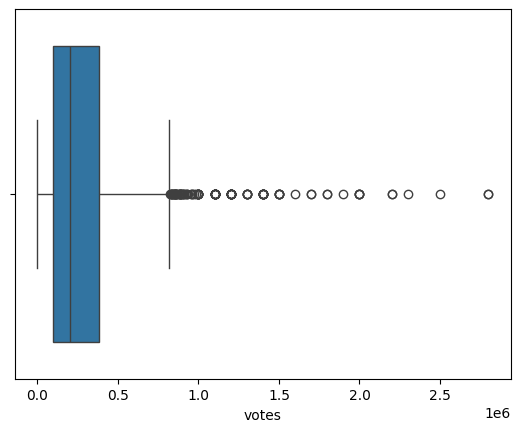

In [16]:
# Create boxplot to visual distribution of votes
sns.boxplot(x=df['votes'])


<Axes: xlabel='votes', ylabel='Count'>

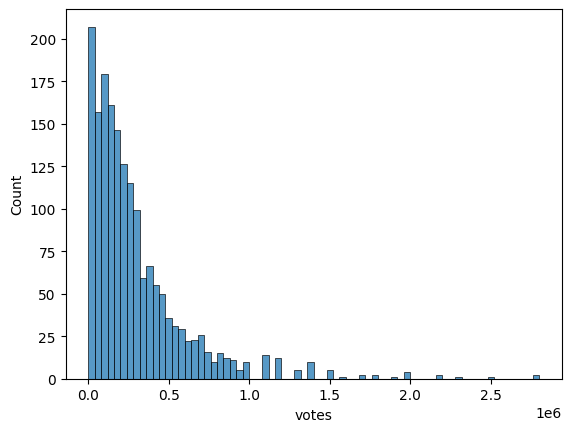

In [17]:
# Create a histogram to better visualize the distribution of votes
sns.histplot(df['votes'], bins=70)


**Analysis:** As you can see, the distribution is right-skewed, which means most of the movies have a low number of votes, and a small number have very high vote counts. We tested different bin sizes, starting at 20 and increasing by 10 up to 70, to see how the shape of the histogram changed. We ended up using 70 bins because it gave us a better view of the outliers without losing the overall picture.

We thought about removing the outliers, but decided to keep them since they likely represent the most popular or well-known movies and could be important for our model. Instead of dropping them, we log transformed the votes column. This helps compress the range, reduce the impact of extreme values, and makes the data easier for the model to interpret.

In [18]:
#Check to see if there are any 0 in our
zero_count = (df['votes']==0).sum()
zero_count

np.int64(0)

In [19]:
# Perform log transform on votes
df['log_votes'] = np.log(df['votes'])
df['log_votes']

,log_votes
0,11.407565
1,9.680344
2,12.542545
3,9.952278
4,8.748305
...,...
1729,12.700769
1730,9.998798
1731,12.055250
1732,12.196022


In [20]:
# Drop Votes column
df = df.drop(columns='votes')

In [21]:
df.head()

,rating,meta_score,year,duration,cast1,cast2,cast3,cast4,director,number_rating,netflix_top_10,weekly_hours_viewed,all_genres,log_votes
0,6.5,67,2023,2.300,Julia Roberts,Mahershala Ali,Ethan Hawke,Myha'la,Sam Esmail,4,1,98700000.0,"[Drama, Mystery, Thriller]",11.407565
1,5.6,37,2023,1.767,Jennifer Garner,Ed Helms,Emma Myers,Brady Noon,McG,2,1,39200000.0,"[Comedy, Family]",9.680344
2,6.3,46,2000,1.733,Jim Carrey,Taylor Momsen,Kelley,Jeffrey Tambor,Ron Howard,2,1,7530000.0,"[Comedy, Family, Fantasy]",12.542545
3,7.0,65,2023,1.700,Adam Sandler,Bill Burr,Cecily Strong,Jason Alexander,Robert MarianettiRobert SmigelDavid Wachtenheim,2,1,61700000.0,"[Animation, Comedy, Family]",9.952278
4,6.5,63,2023,1.683,Thandiwe Newton,Zachary Levi,Bella Ramsey,Imelda Staunton,Sam Fell,2,1,20300000.0,"[Animation, Adventure, Comedy]",8.748305


### Year Feature Conversion

In [22]:
# Convert Year to Movie Age
df['movie_age'] = 2025 - df['year']

In [23]:
# Drop year column
df = df.drop(columns=['year'])
df.head()

,rating,meta_score,duration,cast1,cast2,cast3,cast4,director,number_rating,netflix_top_10,weekly_hours_viewed,all_genres,log_votes,movie_age
0,6.5,67,2.300,Julia Roberts,Mahershala Ali,Ethan Hawke,Myha'la,Sam Esmail,4,1,98700000.0,"[Drama, Mystery, Thriller]",11.407565,2
1,5.6,37,1.767,Jennifer Garner,Ed Helms,Emma Myers,Brady Noon,McG,2,1,39200000.0,"[Comedy, Family]",9.680344,2
2,6.3,46,1.733,Jim Carrey,Taylor Momsen,Kelley,Jeffrey Tambor,Ron Howard,2,1,7530000.0,"[Comedy, Family, Fantasy]",12.542545,25
3,7.0,65,1.700,Adam Sandler,Bill Burr,Cecily Strong,Jason Alexander,Robert MarianettiRobert SmigelDavid Wachtenheim,2,1,61700000.0,"[Animation, Comedy, Family]",9.952278,2
4,6.5,63,1.683,Thandiwe Newton,Zachary Levi,Bella Ramsey,Imelda Staunton,Sam Fell,2,1,20300000.0,"[Animation, Adventure, Comedy]",8.748305,2


### Determine if there is any correlation between features

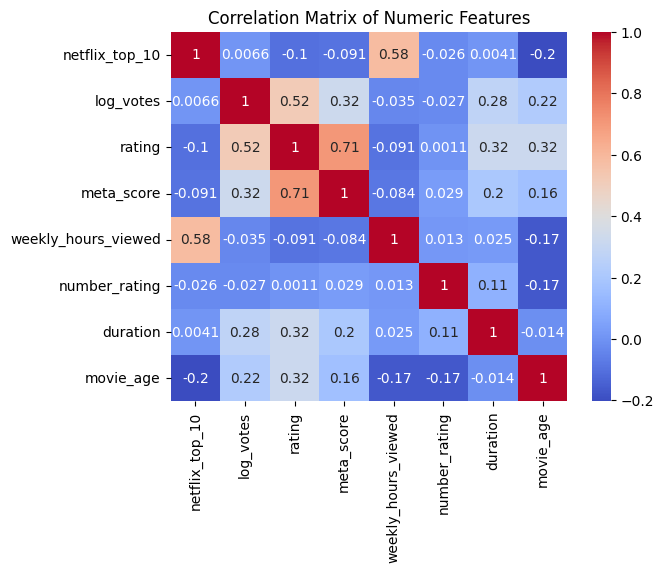

In [24]:
# Select only numeric features including the target
numeric_features = ['netflix_top_10', 'log_votes', 'rating', 'meta_score', 'weekly_hours_viewed', 'number_rating', 'duration', 'movie_age']

# Compute correlation matrix
correlation_matrix = df[numeric_features].corr()

# Visualize
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()


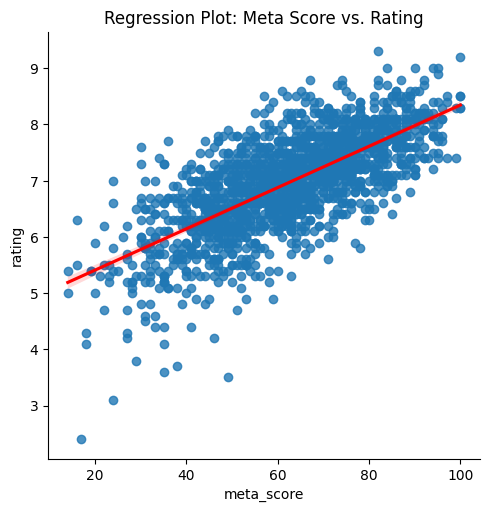

The Pearson Correlation Coefficient: 0.7058305816640229


In [25]:
# Create scatter plot and trend line
sns.lmplot(x='meta_score', y='rating', data=df, line_kws={'color': 'red'})
plt.title('Regression Plot: Meta Score vs. Rating')
plt.show()

# Use .corr() to calculate the Pearson Correlation Coeficient bewteen those two columns
print(f"The Pearson Correlation Coefficient: {df['meta_score'].corr(df['rating'])}")

**Analysis:** This scatter plot shows a **clear positive relationship between meta_score and rating**, with a **correlation of about 0.7**. We saw the same thing in the correlation matrix.

When two features are closely related, we need to be careful about **multicollinearity**. This can be an issue in some models, like logistic regression, because it makes it harder to figure out which variable is actually influencing the prediction.

We noticed that `meta_score` and `rating` might be giving us similar information. While more flexible models like Random Forest can handle this fine, we kept it in mind when using other models and considered dropping one if needed.

### Investigate Top 10 movies Feature

In [26]:
# Check out may movies are in the Top 10 versus not (0=No, 1=Yes)
df['netflix_top_10'].value_counts()

,count
netflix_top_10,
0,1553
1,175


This shows that our data has a **class imbalance**, with way more movies not in the Top 10 than those that are. If we don't address this, the logistic regression model might just predict "no" for everything and still be around 90 percent accurate. That might sound good at first, but it wouldn't actually help us find the movies that do make it into the Top 10, which is the whole point of our model.

To help address this imbalance, we will use class_weight='balanced' in our logistic regression model so it gives more importance to the smaller class.

#### **Why We Used MultiLabelBinarizer Instead of One-Hot Encoding genre0**
The genre0 column listed multiple genres in one string, like "Action, Drama, Horror". Using pd.get_dummies() on that would treat the entire string as one category, so "Action, Drama" and "Drama, Action" would be seen as completely different even though they contain the same genres.

To fix this, we split the string into a list of genres for each movie and used MultiLabelBinarizer. This created separate columns for each genre and marked 1 or 0 depending on whether that genre was included. This way, the model can recognize each genre on its own, no matter the order or how many there are. It's a better fit for situations where a movie can belong to more than one category.

In [27]:
# Need to handle the list we created for `all_genres`
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(df['all_genres']),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=df.index
)


In [28]:
genre_dummies.head()

,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,...,genre_Horror,genre_Music,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Create variable for the rest of the categorical columns
categorical_cols = df[['cast1', 'cast2', 'cast3', 'cast4', 'director']]

# Convert categorical data to numeric with `pd.get_dummies`
categorical_dummies = pd.get_dummies(categorical_cols)


In [30]:
categorical_dummies.head()

,cast1_Aaron Taylor-Johnson,cast1_Abby Ryder Fortson,cast1_Abigail Cowen,cast1_Adam Devine,cast1_Adam Driver,cast1_Adam Sandler,cast1_Adam Scott,cast1_Adrien Brody,cast1_Aileen Quinn,cast1_Al Pacino,...,director_Wim Wenders,director_Wolfgang Petersen,director_Woody Allen,director_Yarrow CheneyScott Mosier,director_Yimou Zhang,director_Yorgos Lanthimos,director_Zach Braff,director_Zach Cregger,director_Zachary Wigon,director_Zack Snyder
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
# Create numeric df
numeric_columns = df[['rating', 'meta_score', 'number_rating', 'weekly_hours_viewed',	'log_votes', 'movie_age']]

In [32]:
numeric_columns.head()

,rating,meta_score,number_rating,weekly_hours_viewed,log_votes,movie_age
0,6.5,67,4,98700000.0,11.407565,2
1,5.6,37,2,39200000.0,9.680344,2
2,6.3,46,2,7530000.0,12.542545,25
3,7.0,65,2,61700000.0,9.952278,2
4,6.5,63,2,20300000.0,8.748305,2


In [33]:
# Split our preprocessed data into our features and target arrays
X = pd.concat([numeric_columns, genre_dummies, categorical_dummies], axis=1)
y = df['netflix_top_10']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [34]:
X.head()

,rating,meta_score,number_rating,weekly_hours_viewed,log_votes,movie_age,genre_Action,genre_Adventure,genre_Animation,genre_Biography,...,director_Wim Wenders,director_Wolfgang Petersen,director_Woody Allen,director_Yarrow CheneyScott Mosier,director_Yimou Zhang,director_Yorgos Lanthimos,director_Zach Braff,director_Zach Cregger,director_Zachary Wigon,director_Zack Snyder
0,6.5,67,4,98700000.0,11.407565,2,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,5.6,37,2,39200000.0,9.680344,2,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,6.3,46,2,7530000.0,12.542545,25,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,7.0,65,2,61700000.0,9.952278,2,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
4,6.5,63,2,20300000.0,8.748305,2,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False


In [35]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Logistical Regression Model**

We started with logistic regression because it's a good first step for binary classification. It gave us a quick baseline to see how well our features could predict if a movie was in the Top 10 or not. From there, we could see its limits and figure out what to try next.

In [36]:
# Create and train the model
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
lr_predictions = model.predict(X_test_scaled)

In [37]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, lr_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, lr_predictions))
print("\nClassification Report:\n", classification_report(y_test, lr_predictions, target_names=['No', 'Yes']))

# Save Logistical Regression Model
joblib.dump(model, 'logistic_regression_model.pkl')

Accuracy: 0.9143518518518519

Confusion Matrix:
 [[388   8]
 [ 29   7]]

Classification Report:
               precision    recall  f1-score   support

          No       0.93      0.98      0.95       396
         Yes       0.47      0.19      0.27        36

    accuracy                           0.91       432
   macro avg       0.70      0.59      0.61       432
weighted avg       0.89      0.91      0.90       432



['logistic_regression_model.pkl']

**Analysis:** The model's **overall accuracy is 91.44%**, which sounds great at first. However, when we look closer at the confusion matrix and classification report, we can see the model does well predicting movies that are not in the Netflix Top 10, but still struggles with those that are.

* Out of 36 actual Top 10 movies, it only correctly identified 7. That is a only 19%, which isn't great, meaning the model is missing most of the true Top 10s.

* The precision for predicting Top 10 is 47%, which means when the model predicts a movie is in the Top 10, it is right less than half the time. The F1 score for class 1 is 0.27, which confirms the model is unbalanced and not performing well across both classes.

* This tells us the model is still biased toward the majority class, and isn't recognizing enough of the actual Top 10s.

Our next step will be to try **SMOTE**. Since the "Yes" class has way fewer examples, SMOTE helps balance the data by creating new examples of the smaller "Yes" class, giving the model a better chance to learn.

**Removed `meta_score` results:** We reran the logistic regression model without `meta_score` to see if it made any difference. The results were basically identical. Accuracy, precision, recall, and F1 scores stayed the same, so removing it didn't improve the model at all.

In [38]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)


In [39]:
# Create and train the model
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_resampled, y_resampled)

# Make predictions
lr_predictions = model.predict(X_test_scaled)

In [40]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, lr_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, lr_predictions))
print("\nClassification Report:\n", classification_report(y_test, lr_predictions, target_names=['No', 'Yes']))

Accuracy: 0.9166666666666666

Confusion Matrix:
 [[390   6]
 [ 30   6]]

Classification Report:
               precision    recall  f1-score   support

          No       0.93      0.98      0.96       396
         Yes       0.50      0.17      0.25        36

    accuracy                           0.92       432
   macro avg       0.71      0.58      0.60       432
weighted avg       0.89      0.92      0.90       432



**Analysis:** The **logistic regression model with SMOTE** has an overall **accuracy of 91.7%**. It does a great job predicting the “No” class, but still struggles with “Yes” predictions. It **only correctly identified 6 out of 36 actual** Top 10s, giving a recall of 17% and a precision of 50%. The F1 score for “Yes” is 0.25, which shows the model is still skewed toward the majority class, and ultimately didn't make a difference.

# **Random Forest Model**
 We tried a random forest model next because it uses decision trees, which makes it more flexible for non-linear data. Since our dataset is unbalanced and not a simple pattern, we expected it to perform better than the logistical regression model.

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)


In [42]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
print("\nClassification Report:\n", classification_report(y_test, rf_predictions, target_names=['No', 'Yes']))

# Save the Random Forest Model
joblib.dump(rf_model, 'random_forest_model.pkl')

Accuracy: 0.9953703703703703

Confusion Matrix:
 [[396   0]
 [  2  34]]

Classification Report:
               precision    recall  f1-score   support

          No       0.99      1.00      1.00       396
         Yes       1.00      0.94      0.97        36

    accuracy                           1.00       432
   macro avg       1.00      0.97      0.98       432
weighted avg       1.00      1.00      1.00       432



['random_forest_model.pkl']

**Analysis:** The **Random Forest model is performing extremely well**, with an overall **accuracy of 99.5%!** It correclty predicted 34 out of 36 that were in the Top 10.

The precision for identifying Top 10 movies is 100%, meaning every time the model predicted a movie would be in the Top 10, it was right. The recall is 94%, so it caught almost all of the actual Top 10s.

The F1 score for class 1 (Yes) is 0.97, which shows that the model is balanced and strong at predicting both classes. This is a big improvement compared to the logistic regression model.

**Overall, this model is doing an amazing job at identifying which movies make it into the Netflix Top 10!**

**Removed `meta_score` results:** We reran the model dropping `meta_score` and it slightly weakened its ability to detect the “Yes” class. This suggests that `meta_score` may have had useful predictive power, even if it was correlated with rating.  Random Forest models can handle multicollinearity better than linear models, so removing meta_score may not have been necessary.

In [43]:
# Check random forest model for overfitting!

# Predict on training data
y_train_pred = rf_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred, target_names=['No', 'Yes']))

# Predict on test data
y_test_pred = rf_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No', 'Yes']))


Training Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      1157
         Yes       1.00      1.00      1.00       139

    accuracy                           1.00      1296
   macro avg       1.00      1.00      1.00      1296
weighted avg       1.00      1.00      1.00      1296

Test Classification Report:
              precision    recall  f1-score   support

          No       0.99      1.00      1.00       396
         Yes       1.00      0.94      0.97        36

    accuracy                           1.00       432
   macro avg       1.00      0.97      0.98       432
weighted avg       1.00      1.00      1.00       432



**Analysis:** To check for overfitting, we looked for signs like a drop of more than 10% in key metrics such as recall, F1 score, or accuracy when comparing the training and test results. Drops like these would signal that the model was just memorizing patterns in the training data instead of learning how to generalize.

Comparing the classification reports helped **confirm the random forest model wasn't overfitting**. It had perfect scores on the training data, which was a concern. But the test results were still strong, with a 1.00 precision and 0.94 recall for the Yes class. This showed the model was working well on new data, not just the data it was trained on.

# **Keras Neural Network Model**

After seeing strong results from the random forest model, we decided to try a Keras neural network to see if a deep learning approach could match or even improve performance.

We wanted to see if this more advanced method could improve Top 10 predictions by capturing complex patterns in our features, since neural networks are good at finding hidden relationships in data.


In [44]:
# Create the Keras Model

# This counts how many features (columns) your data has, so the model knows what kind of input to expect.
number_input_features = len(X_train_scaled[0])

# Used the standard 2 layers and standard neurons(64 and 32) to run a quick test
hidden_nodes_layer1 = 64
hidden_nodes_layer2 = 32

# Start building the Sequential model
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim= number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units= hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       348,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 350,465 (1.34 MB)

 Trainable params: 350,465 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Train the model
# validation_split=0.2 reserves 20% of training data for validation, helping us monitor overfitting and track performance on unseen data.
# batch_size=32 trains the model in small groups, balancing speed, memory use, and generalization.
fit_model_history = nn.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8421 - loss: 0.4691 - val_accuracy: 0.9154 - val_loss: 0.3093
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8985 - loss: 0.2383 - val_accuracy: 0.9192 - val_loss: 0.2920
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9564 - loss: 0.1066 - val_accuracy: 0.9077 - val_loss: 0.3281
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9866 - loss: 0.0459 - val_accuracy: 0.8885 - val_loss: 0.3531
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9998 - loss: 0.0150 - val_accuracy: 0.8654 - val_loss: 0.3686
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9980 - loss: 0.0111 - val_accuracy: 0.8538 - val_loss: 0.3835
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9998 - loss: 0.0068 - val_accuracy: 0.8462 - val_loss: 0.3939
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9994 - loss: 0.0070 - val_accuracy: 0.8462 - v

In [46]:
# Evaluate the model on test data
loss, accuracy = nn.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.2f}, Loss: {loss:.2f}")

# Get predicted probabilities
y_pred_probs = nn.predict(X_test_scaled)

# Convert probabilities to binary class predictions (0 or 1)
y_pred_classes = (y_pred_probs > 0.1).astype("int").flatten()

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=["No", "Yes"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9113 - loss: 0.3887
Test Accuracy: 0.89, Loss: 0.48
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:
[[361  35]
 [ 27   9]]

Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.91      0.92       396
         Yes       0.20      0.25      0.23        36

    accuracy                           0.86       432
   macro avg       0.57      0.58      0.57       432
weighted avg       0.87      0.86      0.86       432



**Analysis:** The overall accuracy is 91%, which sounds great, but the real improvement came after adjusting the threshold from 0.5 to 0.1. Previously, the model only identified 3 out of 36 actual Top 10 movies. After lowering the threshold, it correctly identified 12 out of 36. That increased the recall for Yes from 8% to 33%.

Precision for Yes also improved slightly from 25% to 32%, meaning when the model predicts a Top 10 movie, it's right about a third of the time. The F1 score went from 0.12 to 0.32, showing a more balanced performance between precision and recall.

The model still favors predicting “No,” but adjusting the threshold helped it catch more of the real Top 10s.

**Removed `meta_score` results:** Removing `meta_score` had no impact on the performance of the Keras model. All key metrics, including accuracy, precision, recall, and F1 score for the “Yes” class, remained exactly the same. This suggests that in the neural network's case, meta_score was not contributing anything unique that wasn't already captured by other features like rating.

Since neural networks can handle multicollinearity better than linear models, dropping `meta_score` didn't help or hurt. It just simplified the input slightly without changing results.

In [47]:
#Save file
nn.save('keras_model.keras')

# **Keras Tuner**

Next we used Keras Tuner to help us find the best combination of layers, neurons, and activation functions automatically. This way, we could optimize the model's performance without having to guess the right structure ourselves.

In [48]:
# This counts how many features (columns) your data has, so the model knows what kind of input to expect.
number_input_features = len(X_train_scaled[0])

# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','selu'])

    # Allow kerastuner to decide number of neurons in first layer
    nn.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=8,
        max_value=128,
        step=8), activation=activation, input_dim=number_input_features))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 4)):
        nn.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=8,
            max_value=64,
            step=8),
            activation=activation))
        nn.add(tf.keras.layers.BatchNormalization()) # added after inital testing and the accuracy went down


    # Output layer for binary classification
    nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    # Compile the model
    nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return nn

In [49]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [50]:
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
# Run the Keras Tuner search for best hyperparameters
tuner.search(X_train_scaled, y_train,
             epochs=20,
             validation_split=0.2,
             batch_size=32)


Trial 60 Complete [00h 00m 19s]
val_accuracy: 0.9230769276618958

Best val_accuracy So Far: 0.9461538195610046
Total elapsed time: 00h 10m 48s


In [52]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'first_units': 80,
 'num_layers': 2,
 'units_0': 24,
 'units_1': 16,
 'units_2': 8,
 'units_3': 40,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0049'}

In [53]:
# Evaluate best model from tuner
best_model = tuner.get_best_models(1)[0]

# Evaluate it on the test set
loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f"Best Tuned Model: Test Accuracy: {accuracy:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9276 - loss: 0.3123
Best Tuned Model: Test Accuracy: 0.91


# **Optimized Keras Model**

In [54]:
# Create the Keras Model

# This counts how many features (columns) your data has, so the model knows what kind of input to expect.
number_input_features = len(X_train_scaled[0])

# Layers
hidden_nodes_layer1 = 16
hidden_nodes_layer2 = 24
hidden_nodes_layer3 = 16

# Start building the Sequential model
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim= number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units= hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units= hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
# validation_split=0.2 reserves 20% of training data for validation, helping us monitor overfitting and track performance on unseen data.
# batch_size=32 trains the model in small groups, balancing speed, memory use, and generalization.
fit_model_history = nn.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │        87,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,121 (344.22 KB)

 Trainable params: 88,121 (344.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5377 - loss: 0.7075 - val_accuracy: 0.7808 - val_loss: 0.5777
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8800 - loss: 0.3558 - val_accuracy: 0.8308 - val_loss: 0.5082
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8941 - loss: 0.2200 - val_accuracy: 0.8577 - val_loss: 0.4867
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9179 - loss: 0.1398 - val_accuracy: 0.8654 - val_loss: 0.4769
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9437 - loss: 0.0944 - val_accuracy: 0.8000 - val_loss: 0.4942
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9805 - loss: 0.0579 - val_accuracy: 0.7808 - val_loss: 0.5011
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9825 - loss: 0.0486 - val_accuracy: 0.7423 - val_loss: 0.5076
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9874 - loss: 0.0340 - val_accuracy: 0.7000 - v

In [55]:
# Evaluate the model on test data
loss, accuracy = nn.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.2f}, Loss: {loss:.2f}")

# Get predicted probabilities
y_pred_probs = nn.predict(X_test_scaled)

# Convert probabilities to binary class predictions (0 or 1)
y_pred_classes = (y_pred_probs > 0.1).astype("int").flatten()

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=["No", "Yes"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8955 - loss: 0.6062 
Test Accuracy: 0.88, Loss: 0.71
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Confusion Matrix:
[[342  54]
 [ 26  10]]

Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.86      0.90       396
         Yes       0.16      0.28      0.20        36

    accuracy                           0.81       432
   macro avg       0.54      0.57      0.55       432
weighted avg       0.86      0.81      0.84       432



**Analysis:** The **tuned Keras model** reached a test accuracy of 88%, which sounds strong overall. However, a closer look at the confusion matrix and classification report shows that the model still struggles with predicting movies that are in the Top 10.

Out of 36 actual Top 10 movies, it only correctly identified 8. The precision for predicting Top 10 is 24%, meaning when the model predicts a movie is in the Top 10, it's only right about a quarter of the time. The recall is 22%, so it's missing most of the actual Top 10s. The F1 score for Top 10 is just 0.23, reflecting an imbalance in how well the model handles both classes.

This model is still biased toward predicting the "No" class and has limited ability to accurately identify Top 10 titles.

# **Tested LeakyReLu Activation with tuned model**
Finally, we tried LeakyReLU to see if using a different activation function would improve the keras model. In the end, it didn't solve the overfitting issue we were seeing, so the results stayed about the same.

In [56]:
# Count number of input features
number_input_features = len(X_train_scaled[0])

# Define hidden layer sizes
hidden_nodes_layer1 = 16
hidden_nodes_layer2 = 24
hidden_nodes_layer3 = 16

# Build the model
nn = tf.keras.models.Sequential()

# Input layer + Leaky ReLU
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features))
nn.add(LeakyReLU(alpha=0.1))

# Hidden layers + Leaky ReLU
nn.add(Dense(units=hidden_nodes_layer2))
nn.add(LeakyReLU(alpha=0.1))

nn.add(Dense(units=hidden_nodes_layer3))
nn.add(LeakyReLU(alpha=0.1))

nn.add(LeakyReLU(alpha=0.1))

# Output layer
nn.add(Dense(units=1, activation="sigmoid"))

# Print summary
nn.summary()

# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
# validation_split=0.2 reserves 20% of training data for validation, helping us monitor overfitting and track performance on unseen data.
# batch_size=32 trains the model in small groups, balancing speed, memory use, and generalization.
fit_model_history = nn.fit(X_train_scaled, y_train, epochs=20, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 16)             │        87,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,913 (343.41 KB)

 Trainable params: 87,913 (343.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8459 - loss: 0.5248
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8927 - loss: 0.2688
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8824 - loss: 0.1858
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9025 - loss: 0.1079
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9289 - loss: 0.0887
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9819 - loss: 0.0749
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0519
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0166
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9957 - loss: 0.0080
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0025
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0025
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - lo

In [57]:
# Evaluate the model on test data
loss, accuracy = nn.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.2f}, Loss: {loss:.2f}")

# Get predicted probabilities
y_pred_probs = nn.predict(X_test_scaled)

# Convert probabilities to binary class predictions (0 or 1)
y_pred_classes = (y_pred_probs > 0.1).astype("int").flatten()

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=["No", "Yes"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8626 - loss: 0.4896  
Test Accuracy: 0.85, Loss: 0.56
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:
[[312  84]
 [ 16  20]]

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.79      0.86       396
         Yes       0.19      0.56      0.29        36

    accuracy                           0.77       432
   macro avg       0.57      0.67      0.57       432
weighted avg       0.89      0.77      0.81       432



**Analysis:** The model with LeakyReLU had a solid accuracy of 89%, but it's still favoring the “No” class. It only got 10 out of 36 “Yes” predictions right.

Precision for Yes is 20%, so it's wrong most of the time when it predicts Top 10

Recall for Yes is 28%, so it' only finding about a quarter of the actual Top 10s

F1 score is just 0.23, which shows the model is still unbalanced

**Even with LeakyReLU, the model didn't improve much in predicting the “Yes” class.**

# **Overall Takeaway:**
The **Random Forest model** outperformed the Neural Network in almost every way! It delivered high accuracy on both training and test sets without overfitting, with strong precision, recall, and F1 scores for both classes. It did especially well at correctly identifying the minority “Yes” class, which is impressive given the imbalance in the data.

The **Neural Network**, even with tuning and using different activation functions like LeakyReLU, struggled to improve performance on the “Yes” class. While its overall accuracy was decent, precision and recall for the “Yes” class remained low. This showed that the model wasn't picking up on the patterns needed to detect those cases.

**In conclusion, the answer to our original quesiton is YES!** We can predict if a movie will be in Netflix Top 10 List using our Random Forest Model. **Random Forest handled the imbalance better and gave more reliable, balanced results for our classification problem.**